In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stratx import featimp
from stratx.partdep import *
from rfpimp import plot_importances

%config InlineBackend.figure_formats = ['svg','png']


In [36]:
def synthetic_poly_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    # df['x3'] = df['x1']  # copy x1
    # multiply coefficients x each column (var) and sum along columns
    df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    #TODO add noise
    terms = [f"{coeff[i]:.1f}x_{i+1}" for i in range(p)]
    eqn = "y = " + '+'.join(terms)
    return df, coeff, eqn

In [37]:
def synthetic_poly2_data(n, p):
    df = pd.DataFrame()
    # Add independent x variables in [0.0, 1.0)
    coeff = np.random.random_sample(size=p)*10 # get p random coefficients
    coeff = np.array([5, 2, 10])
    for i in range(p):
        df[f'x{i+1}'] = np.round(np.random.random_sample(size=n)*10,1)
    # df['x3'] = df['x1']  # copy x1
    # multiply coefficients x each column (var) and sum along columns
    # df['y'] = np.sum( [coeff[i]*df[f'x{i+1}'] for i in range(p)], axis=0 )
    df['y'] = 5*df['x1'] - 3*df['x2'] + 3*df['x3']**2
    #TODO add noise
    return df, coeff, "y = 5 x_1 - 3 x_2 + 3 x_3"

In [47]:
palette = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
    "#ffff99", 
    "#b15928"
]
def plot_all_PD(X,y,eqn=None,min_samples_leaf=5):
    fig, ax = plt.subplots(1,1)
    for i,colname in enumerate(X.columns):
        plot_stratpd(X, y, colname, 'y', ax=ax, min_samples_leaf=min_samples_leaf,
                     show_slope_lines=False,
                     pdp_marker_color=palette[i])
#     uniq_x = np.array(sorted(np.unique(X[:,0])))
#     ax2 = ax.twinx()
    record_x = range(len(y))
    record_x = (record_x - np.mean(record_x)) / np.std(record_x)
    ax.plot(record_x, y, lw=.3, c='k', label='marginal $y$ vs $x^{(i)}$')
    if eqn is not None:
        plt.title(f"${eqn}$")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Synthetic degree 1 polynomial

In [48]:
df, coeff, eqn = synthetic_poly_data(500,3)
df.head()

,x1,x2,x3,y
0,2.8,5.5,9.0,46.808569
1,1.1,2.1,4.3,19.908534
2,4.0,1.5,0.1,9.273188
3,1.6,9.7,1.4,46.683102
4,2.4,0.8,8.5,24.838079


In [49]:
X = df.drop('y', axis=1)
y = df['y']

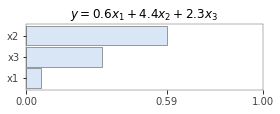

In [50]:
X = featimp.standardize(X)
I = featimp.importances(X, y)
plot_importances(I, imp_range=(0,1))
plt.title(f"${eqn}$")
plt.show()

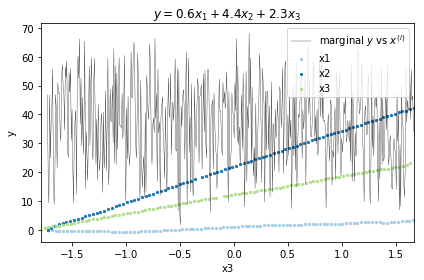

In [51]:
plot_all_PD(X,y,eqn)

## Synthetic degree 2 polynomial

In [43]:
df, coeff, eqn = synthetic_poly2_data(500,3)
df.head()

,x1,x2,x3,y
0,0.1,3.5,4.9,62.03
1,9.0,0.1,4.3,100.17
2,5.7,5.9,2.0,22.80
3,4.4,2.8,6.5,140.35
4,3.7,8.3,0.5,-5.65


In [44]:
X = df.drop('y', axis=1)
y = df['y']

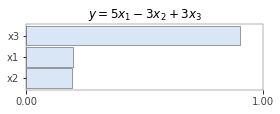

In [45]:
X = featimp.standardize(X)
I = featimp.importances(X, y)
plot_importances(I, imp_range=(0,1))
plt.title(f"${eqn}$")
plt.show()

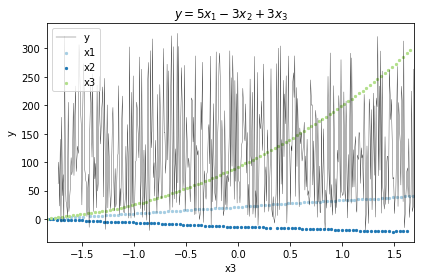

In [46]:
plot_all_PD(X,y,eqn)